<a href="https://colab.research.google.com/github/SalmanOkz/Deep_Learning_Finance_Project/blob/main/Deep_Learning_Assingemnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/creditcard.csv")
print("Dataset Shape:", df.shape)
df.head()

# Check class distribution
print(df['Class'].value_counts())
print(df['Class'].value_counts(normalize=True))


Dataset Shape: (5974, 31)
Class
0.0    5970
1.0       3
Name: count, dtype: int64
Class
0.0    0.999498
1.0    0.000502
Name: proportion, dtype: float64


Initial Class Distribution:

       Count  Percentage (%)
Class                       
0.0     5970         99.9498
1.0        3          0.0502


/tmp/ipython-input-2921727251.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='coolwarm')


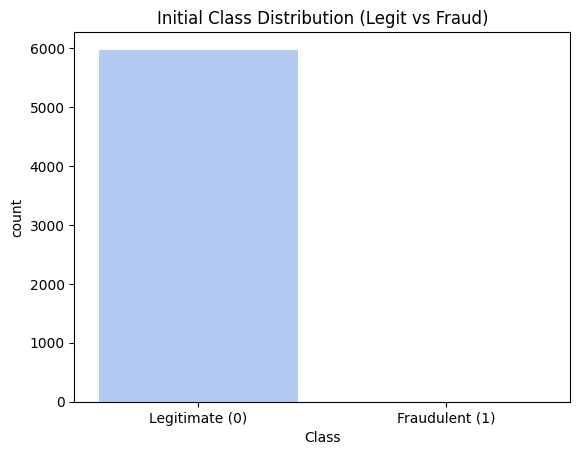

In [4]:
class_counts = df['Class'].value_counts()
class_percent = df['Class'].value_counts(normalize=True) * 100

report_df = pd.DataFrame({
    'Count': class_counts,
    'Percentage (%)': class_percent.round(4)
})

print("Initial Class Distribution:\n")
print(report_df)

# Optional: Visualization
sns.countplot(x='Class', data=df, palette='coolwarm')
plt.title('Initial Class Distribution (Legit vs Fraud)')
plt.xticks([0,1], ['Legitimate (0)', 'Fraudulent (1)'])
plt.show()

In [16]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [5]:
# ===========================
# 4. Feature Scaling (Time & Amount only)
# ===========================
scaler = StandardScaler()

df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

print("Scaled 'Time' and 'Amount' features successfully.")
df[['Time', 'Amount']].head()


Scaled 'Time' and 'Amount' features successfully.


,Time,Amount
0,-1.517168,0.439322
1,-1.517168,-0.324053
2,-1.516601,1.629300
3,-1.516601,0.303616
4,-1.516034,0.025604


In [7]:
# ===========================
# 5. Split into Train (70%), Validation (15%), Test (15%)
# ===========================
X = df.drop('Class', axis=1)
y = df['Class']

# First: Train vs temp (85/15 split)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,  # 30% goes to temp (15 val + 15 test)
    stratify=y,
    random_state=42
)

# Now: Split temp into validation and test equally (15% each overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Confirm splits
print(f"Training set:   {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set:       {len(X_test)} samples")

# Confirm that validation and test sets retain imbalance
print("\nValidation set class distribution:")
print(y_val.value_counts(normalize=True) * 100)

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True) * 100)


ValueError: Input y contains NaN.

In [ ]:
# ===========================
# 6. Apply SMOTE (Training Set Only)
# ===========================
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_res.value_counts())


In [ ]:
# ===========================
# 7. Visualize Before vs After SMOTE
# ===========================
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(x=y_train, ax=ax[0], palette='coolwarm')
ax[0].set_title('Before SMOTE (Training Set)')
ax[0].set_xticklabels(['Legit (0)', 'Fraud (1)'])

sns.countplot(x=y_train_res, ax=ax[1], palette='coolwarm')
ax[1].set_title('After SMOTE (Balanced Training Set)')
ax[1].set_xticklabels(['Legit (0)', 'Fraud (1)'])

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Just to be sure, check input dimension
input_dim = X_train_res.shape[1]
print("Input feature dimension:", input_dim)   # should be 30

# ===============================
# 1. Build the Baseline NN Model
# ===============================
baseline_model = keras.Sequential([
    # Input layer is implied by input_dim in first Dense
    layers.Dense(64, activation='relu', input_dim=input_dim),
    layers.Dropout(0.2),                      # Dropout Layer 1 (rate = 0.2)
    layers.Dense(32, activation='relu'),      # Dense Layer 2: 32 units, ReLU
    layers.Dense(1, activation='sigmoid')     # Output Layer: 1 unit, Sigmoid
])

# ===============================
# 2. Compile the Model
# ===============================
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

baseline_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall')  # Track recall explicitly
    ]
)

baseline_model.summary()
